In [258]:
import pandas as pd
import yfinance as yf
import numpy as np
import glob
import os
from matplotlib.dates import MonthLocator, DateFormatter
import seaborn as sns
import plotly.express as px
import simpful as sf
from simpful import *
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import backtesting
from backtesting import Backtest, Strategy
from backtesting.lib import SignalStrategy

backtesting.set_bokeh_output(notebook=True)


In [242]:
#at_eur_1h = pd.read_csv('data/indicators_eurusd_1h.csv')

In [259]:
data = pd.read_csv('data/indicators_eurusd_d.csv')
data

,Date,Open,High,Low,Close,Name,Return,Up,Down,avg_14up,...,12Ewm,26Ewm,MACD,low_14,high_14,k_percent,r_percent,B_MA,BU,BL
0,2020-01-29,1.10220,1.10277,1.09926,1.10105,EURUSD,-0.001044,0.000000,0.001044,0.000463,...,1.106465,1.110141,-0.003676,1.09926,1.11713,10.016788,-89.983212,1.110335,1.121102,1.099567
1,2020-01-30,1.10103,1.10396,1.10076,1.10341,EURUSD,0.002141,0.002141,0.000000,0.000518,...,1.105995,1.109642,-0.003647,1.09926,1.11713,23.223279,-76.776721,1.109646,1.120332,1.098960
2,2020-01-31,1.10336,1.10916,1.10171,1.10903,EURUSD,0.005080,0.005080,0.000000,0.000792,...,1.106462,1.109597,-0.003135,1.09926,1.11713,54.672636,-45.327364,1.109289,1.119524,1.099054
3,2020-02-03,1.10859,1.10908,1.10369,1.10594,EURUSD,-0.002790,0.000000,0.002790,0.000792,...,1.106382,1.109326,-0.002944,1.09926,1.11713,37.381086,-62.618914,1.108607,1.117710,1.099504
4,2020-02-04,1.10593,1.10641,1.10332,1.10452,EURUSD,-0.001285,0.000000,0.001285,0.000636,...,1.106095,1.108970,-0.002875,1.09926,1.11713,29.434807,-70.565193,1.108094,1.116884,1.099304
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1011,2023-12-25,1.10175,1.10255,1.10121,1.10150,EURUSD,0.000209,0.000209,0.000000,0.002714,...,1.094173,1.088813,0.005360,1.07246,1.10402,92.015209,-7.984791,1.089533,1.107951,1.071115
1012,2023-12-26,1.10144,1.10456,1.10089,1.10415,EURUSD,0.002403,0.002403,0.000000,0.002885,...,1.095708,1.089949,0.005759,1.07246,1.10456,98.722741,-1.277259,1.089771,1.108839,1.070704
1013,2023-12-27,1.10418,1.11226,1.10288,1.11060,EURUSD,0.005825,0.005825,0.000000,0.003135,...,1.097999,1.091479,0.006520,1.07246,1.11226,95.829146,-4.170854,1.090442,1.111451,1.069432
1014,2023-12-28,1.11059,1.11395,1.10554,1.10623,EURUSD,-0.003943,0.000000,0.003943,0.003135,...,1.099265,1.092572,0.006694,1.07418,1.11395,80.588383,-19.411617,1.091294,1.113440,1.069148


### =====================
[Simpful on github](https://github.com/aresio/simpful/blob/master/simpful/simpful.py)
### =====================

## RSI decision

In [260]:
def decision_rsi(df):
    df['dec_rsi'] = 'HOLD'  

    df.loc[df['RSI'] < 30, 'dec_rsi'] = 'BUY'
    df.loc[df['RSI'] > 70, 'dec_rsi'] = 'SELL'

    return df

In [261]:
decision_rsi(data)
data['dec_rsi'].value_counts()

dec_rsi
HOLD    767
BUY     131
SELL    118
Name: count, dtype: int64

decision_rsi(at_eur_1h)
at_eur_1h['dec_rsi'].value_counts()

In [262]:
#########
at_eur_1h = data
#########

In [263]:
FS = sf.FuzzySystem()


# linguistic variable for the input
S1 = sf.FuzzySet(points=[[0, 1.], [30, 1.], [50, 0.]], term="low")
S2 = sf.FuzzySet(points=[[50, 1.], [51, 1.], [61, 0.]], term="medium")
S3 = sf.FuzzySet(points=[[61, 0.], [70, 1.], [100, 1.]], term="high")
LV = sf.LinguisticVariable([S1, S2, S3], universe_of_discourse=[0, 100])
FS.add_linguistic_variable("RSI", LV)


# linguistic variable for the output
# 0-0.3 = SELL, 0.5-0.7 = HOLD, 0.7-1 = BUY
S1 = sf.FuzzySet(points=[[0, 1.], [0.3, 1.], [0.7, 0.]], term="BUY")
S2 = sf.FuzzySet(points=[[0.3, 0.], [0.5, 1.], [0.7, 0.]], term="HOLD")
S3 = sf.FuzzySet(points=[[0.3, 0.], [0.7, 1.], [1.0, 1.]], term="SELL")
LV = sf.LinguisticVariable([S1, S2, S3], universe_of_discourse=[0, 1])
FS.add_linguistic_variable("Signal_RSI_fuzz_system", LV)


R1 = "IF (RSI IS low) THEN (Signal_RSI_fuzz_system IS SELL)"
R2 = "IF (RSI IS medium) THEN (Signal_RSI_fuzz_system IS HOLD)"
R3 = "IF (RSI IS high) THEN (Signal_RSI_fuzz_system IS BUY)"
FS.add_rules([R1, R2, R3])

at_eur_1h['Signal_RSI_fuzz_system'] = 'HOLD' 

# generate signals
for i, value in enumerate(at_eur_1h['RSI']):
    FS.set_variable("RSI", value)
    decision = FS.Mamdani_inference()['Signal_RSI_fuzz_system']
    
    if decision <= 0.3:
        at_eur_1h.loc[at_eur_1h.index[i], 'Signal_RSI_fuzz_system'] = 'SELL'
    elif decision >= 0.7:
        at_eur_1h.loc[at_eur_1h.index[i], 'Signal_RSI_fuzz_system'] = 'BUY'



  ____  __  _  _  ____  ____  _  _  __   
 / ___)(  )( \/ )(  _ \(  __)/ )( \(  ) v2.11.1 
 \___ \ )( / \/ \ ) __/ ) _) ) \/ (/ (_/\ 
 (____/(__)\_)(_/(__)  (__)  \____/\____/

 Created by Marco S. Nobile (m.s.nobile@tue.nl)
 and Simone Spolaor (simone.spolaor@unimib.it)



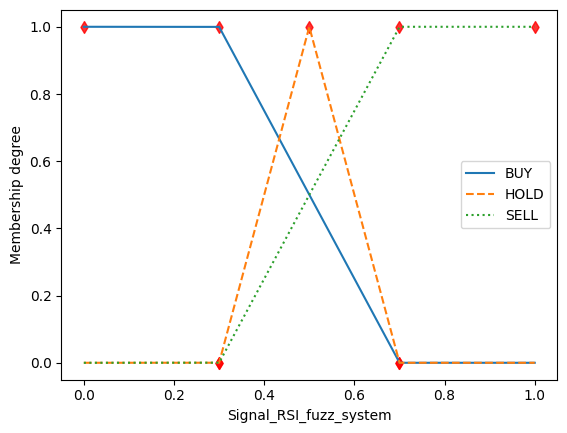

In [264]:
FS.plot_variable('Signal_RSI_fuzz_system')

In [265]:
at_eur_1h['Signal_RSI_fuzz_system'].value_counts()

Signal_RSI_fuzz_system
HOLD    699
SELL    175
BUY     142
Name: count, dtype: int64

## Backtesting

### ========

[Backtesting on github](https://github.com/kernc/backtesting.py/blob/master/backtesting/backtesting.py#L1014)
### ========

     `cash` is the initial cash to start with.

        `commission` is the commission ratio. E.g. if your broker's commission
        is 1% of trade value, set commission to `0.01`. Note, if you wish to
        account for bid-ask spread, you can approximate doing so by increasing
        the commission, e.g. set it to `0.0002` for commission-less forex
        trading where the average spread is roughly 0.2‰ of asking price.

        `margin` is the required margin (ratio) of a leveraged account.
        No difference is made between initial and maintenance margins.
        To run the backtest using e.g. 50:1 leverge that your broker allows,
        set margin to `0.02` (1 / leverage).

        If `trade_on_close` is `True`, market orders will be filled
        with respect to the current bar's closing price instead of the
        next bar's open.

        If `hedging` is `True`, allow trades in both directions simultaneously.
        If `False`, the opposite-facing orders first close existing trades in
        a [FIFO] manner.

        If `exclusive_orders` is `True`, each new order auto-closes the previous
        trade/position, making at most a single trade (long or short) in effect
        at each time.


In [266]:
at_eur_1h.tail()

,Date,Open,High,Low,Close,Name,Return,Up,Down,avg_14up,...,MACD,low_14,high_14,k_percent,r_percent,B_MA,BU,BL,dec_rsi,Signal_RSI_fuzz_system
1011,2023-12-25,1.10175,1.10255,1.10121,1.10150,EURUSD,0.000209,0.000209,0.000000,0.002714,...,0.005360,1.07246,1.10402,92.015209,-7.984791,1.089533,1.107951,1.071115,HOLD,SELL
1012,2023-12-26,1.10144,1.10456,1.10089,1.10415,EURUSD,0.002403,0.002403,0.000000,0.002885,...,0.005759,1.07246,1.10456,98.722741,-1.277259,1.089771,1.108839,1.070704,SELL,SELL
1013,2023-12-27,1.10418,1.11226,1.10288,1.11060,EURUSD,0.005825,0.005825,0.000000,0.003135,...,0.006520,1.07246,1.11226,95.829146,-4.170854,1.090442,1.111451,1.069432,SELL,SELL
1014,2023-12-28,1.11059,1.11395,1.10554,1.10623,EURUSD,-0.003943,0.000000,0.003943,0.003135,...,0.006694,1.07418,1.11395,80.588383,-19.411617,1.091294,1.113440,1.069148,SELL,SELL
1015,2023-12-29,1.10628,1.10842,1.10384,1.10410,EURUSD,-0.001927,0.000000,0.001927,0.003127,...,0.006584,1.07613,1.11395,73.955579,-26.044421,1.092102,1.114903,1.069300,SELL,SELL


In [268]:
at_eur_1h[['RSI', 'dec_rsi', 'Signal_RSI_fuzz_system']].tail(20)

,RSI,dec_rsi,Signal_RSI_fuzz_system
996,45.469581,HOLD,HOLD
997,44.187304,HOLD,HOLD
998,40.967111,HOLD,HOLD
999,37.078812,HOLD,HOLD
1000,29.814941,BUY,BUY
1001,32.211315,HOLD,HOLD
1002,39.210287,HOLD,HOLD
1003,47.029042,HOLD,HOLD
1004,54.211905,HOLD,HOLD
1005,45.379442,HOLD,HOLD


## Fuzzy

In [12]:
#at_eur_1h['data_datetime'] = pd.to_datetime(at_eur_1h['data_datetime'])
#at_eur_1h = at_eur_1h.set_index('data_datetime')

class CustomStrategy(SignalStrategy):
    def init(self):
        super().init()
        self.set_signal(at_eur_1h['Signal_RSI_fuzz_system'] == 'BUY', 
                        at_eur_1h['Signal_RSI_fuzz_system'] == 'SELL')
        
# zamienic na -1 i 1, 0
# 1 na long -1 na short
bt = Backtest(at_eur_1h, CustomStrategy, commission=0.01, exclusive_orders=True)
stats = bt.run()
bt.plot()
stats


# Backtesting

In [269]:
# zmiana decyzji na -1, 0, 1
at_eur_1h['Signal_RSI_fuzz_system'] = at_eur_1h['Signal_RSI_fuzz_system'].replace({'BUY': 1, 'HOLD': 0, 'SELL': -1})


# zmiana na datę
#at_eur_1h['Date'] = pd.to_datetime(at_eur_1h['Date'])

In [271]:
at_eur_1h

,Date,Open,High,Low,Close,Name,Return,Up,Down,avg_14up,...,MACD,low_14,high_14,k_percent,r_percent,B_MA,BU,BL,dec_rsi,Signal_RSI_fuzz_system
0,2020-01-29,1.10220,1.10277,1.09926,1.10105,EURUSD,-0.001044,0.000000,0.001044,0.000463,...,-0.003676,1.09926,1.11713,10.016788,-89.983212,1.110335,1.121102,1.099567,BUY,1
1,2020-01-30,1.10103,1.10396,1.10076,1.10341,EURUSD,0.002141,0.002141,0.000000,0.000518,...,-0.003647,1.09926,1.11713,23.223279,-76.776721,1.109646,1.120332,1.098960,HOLD,0
2,2020-01-31,1.10336,1.10916,1.10171,1.10903,EURUSD,0.005080,0.005080,0.000000,0.000792,...,-0.003135,1.09926,1.11713,54.672636,-45.327364,1.109289,1.119524,1.099054,HOLD,0
3,2020-02-03,1.10859,1.10908,1.10369,1.10594,EURUSD,-0.002790,0.000000,0.002790,0.000792,...,-0.002944,1.09926,1.11713,37.381086,-62.618914,1.108607,1.117710,1.099504,HOLD,0
4,2020-02-04,1.10593,1.10641,1.10332,1.10452,EURUSD,-0.001285,0.000000,0.001285,0.000636,...,-0.002875,1.09926,1.11713,29.434807,-70.565193,1.108094,1.116884,1.099304,HOLD,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1011,2023-12-25,1.10175,1.10255,1.10121,1.10150,EURUSD,0.000209,0.000209,0.000000,0.002714,...,0.005360,1.07246,1.10402,92.015209,-7.984791,1.089533,1.107951,1.071115,HOLD,-1
1012,2023-12-26,1.10144,1.10456,1.10089,1.10415,EURUSD,0.002403,0.002403,0.000000,0.002885,...,0.005759,1.07246,1.10456,98.722741,-1.277259,1.089771,1.108839,1.070704,SELL,-1
1013,2023-12-27,1.10418,1.11226,1.10288,1.11060,EURUSD,0.005825,0.005825,0.000000,0.003135,...,0.006520,1.07246,1.11226,95.829146,-4.170854,1.090442,1.111451,1.069432,SELL,-1
1014,2023-12-28,1.11059,1.11395,1.10554,1.10623,EURUSD,-0.003943,0.000000,0.003943,0.003135,...,0.006694,1.07418,1.11395,80.588383,-19.411617,1.091294,1.113440,1.069148,SELL,-1


In [252]:
#at_eur_1h.reset_index(drop=True, inplace=True)
#at_eur_1h.set_index('Date', inplace=True)


In [272]:
at_eur_1h.Signal_RSI_fuzz_system.value_counts()

Signal_RSI_fuzz_system
 0    699
-1    175
 1    142
Name: count, dtype: int64

In [273]:
class ExampleStrategy(SignalStrategy):
    def init(self):
        super().init()
        signal_data = self.data.df['Signal_RSI_fuzz_system'].copy()
        self.buy_signal = signal_data == 1
        self.sell_signal = signal_data == -1
        self.position_open = False  
        self.current_index = 0  
    
    def next(self):
        super().next()
        current_index = self.data.index[self.current_index]  # Zmieniono nazwę zmiennej
        
        if current_index in self.buy_signal.index and self.buy_signal.loc[current_index] and not self.position_open:
            print(f"Buying at index {current_index}, Cash: {self.equity}")
            self.buy()
            self.buy_signal[current_index] = False 
            self.position_open = True  
        elif current_index in self.sell_signal.index and self.sell_signal.loc[current_index] and self.position_open:
            print(f"Selling at index {current_index}, Cash: {self.equity}")
            self.sell()
            self.sell_signal[current_index] = False  
            self.position_open = False  
        
        self.current_index += 1

bt = Backtest(at_eur_1h, ExampleStrategy, commission=0, exclusive_orders=False)
stats = bt.run()
bt.plot()

stats


C:\Users\Karolina\AppData\Local\Temp\ipykernel_3864\182453494.py:27: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  bt = Backtest(at_eur_1h, ExampleStrategy, commission=0, exclusive_orders=False)


Buying at index 0, Cash: 10000
Selling at index 23, Cash: 10124.1631
Buying at index 169, Cash: 10578.49129
Selling at index 209, Cash: 10758.48247
Buying at index 285, Cash: 10787.212180000002
Selling at index 311, Cash: 10846.30294
Buying at index 356, Cash: 10790.928010000001
Selling at index 414, Cash: 10734.55615
Buying at index 425, Cash: 10597.886110000001
Selling at index 452, Cash: 10476.713800000001
Buying at index 465, Cash: 10257.75172
Selling at index 531, Cash: 10297.628920000001
Buying at index 537, Cash: 10210.533490000002
Selling at index 605, Cash: 9741.070090000001
Buying at index 613, Cash: 9439.997230000003
Selling at index 648, Cash: 9212.334670000002
Buying at index 665, Cash: 9042.0409
Selling at index 710, Cash: 9033.431050000001
Buying at index 793, Cash: 9612.194230000001
Selling at index 817, Cash: 9826.352920000001
Buying at index 852, Cash: 9824.540320000002
Selling at index 874, Cash: 9910.820080000001
Buying at index 908, Cash: 9923.780170000002
Selling 

Start                                     0.0
End                                    1015.0
Duration                               1015.0
Exposure Time [%]                    99.80315
Equity Final [$]                  10026.46396
Equity Peak [$]                   11173.11472
Return [%]                            0.26464
Buy & Hold Return [%]                0.277008
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                  -22.162875
Avg. Drawdown [%]                    -3.09106
Max. Drawdown Duration                  773.0
Avg. Drawdown Duration              76.769231
# Trades                                  1.0
Win Rate [%]                            100.0
Best Trade [%]                       0.264646
Worst Trade [%]                      0.264646
Avg. Trade [%]                    

## Sharp

In [15]:
class CustomStrategy(SignalStrategy):
    def init(self):
        super().init()
        self.set_signal(at_eur_1h['dec_rsi'] == 'BUY', 
                        at_eur_1h['dec_rsi'] == 'SELL')

bt = Backtest(at_eur_1h, CustomStrategy, commission=0.01, exclusive_orders=True)
stats = bt.run()
bt.plot()
stats

C:\Users\Karolina\AppData\Local\Temp\ipykernel_13104\3263418944.py:7: UserWarning: Data index is not sorted in ascending order. Sorting.
  bt = Backtest(at_eur_1h, CustomStrategy, commission=0.01, exclusive_orders=True)
C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


Start                     2023-01-05 09:00:00
End                       2023-11-21 11:00:00
Duration                    320 days 02:00:00
Exposure Time [%]                   48.777736
Equity Final [$]                  9993.404734
Equity Peak [$]                       10000.0
Return [%]                          -0.065953
Buy & Hold Return [%]                1.754957
Return (Ann.) [%]                   -0.062016
Volatility (Ann.) [%]                0.006399
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -0.065954
Avg. Drawdown [%]                   -0.065954
Max. Drawdown Duration      307 days 05:00:00
Avg. Drawdown Duration      307 days 05:00:00
# Trades                                  609
Win Rate [%]                              0.0
Best Trade [%]                      -0.062574
Worst Trade [%]                     -1.838173
Avg. Trade [%]                    

# Williams %R ('r_percent')

In [274]:
at_eur_1h.head()

,Date,Open,High,Low,Close,Name,Return,Up,Down,avg_14up,...,MACD,low_14,high_14,k_percent,r_percent,B_MA,BU,BL,dec_rsi,Signal_RSI_fuzz_system
0,2020-01-29,1.10220,1.10277,1.09926,1.10105,EURUSD,-0.001044,0.000000,0.001044,0.000463,...,-0.003676,1.09926,1.11713,10.016788,-89.983212,1.110335,1.121102,1.099567,BUY,1
1,2020-01-30,1.10103,1.10396,1.10076,1.10341,EURUSD,0.002141,0.002141,0.000000,0.000518,...,-0.003647,1.09926,1.11713,23.223279,-76.776721,1.109646,1.120332,1.098960,HOLD,0
2,2020-01-31,1.10336,1.10916,1.10171,1.10903,EURUSD,0.005080,0.005080,0.000000,0.000792,...,-0.003135,1.09926,1.11713,54.672636,-45.327364,1.109289,1.119524,1.099054,HOLD,0
3,2020-02-03,1.10859,1.10908,1.10369,1.10594,EURUSD,-0.002790,0.000000,0.002790,0.000792,...,-0.002944,1.09926,1.11713,37.381086,-62.618914,1.108607,1.117710,1.099504,HOLD,0
4,2020-02-04,1.10593,1.10641,1.10332,1.10452,EURUSD,-0.001285,0.000000,0.001285,0.000636,...,-0.002875,1.09926,1.11713,29.434807,-70.565193,1.108094,1.116884,1.099304,HOLD,0


In [275]:
at_eur_1h._percent.describe()

count    1016.000000
mean      -51.222510
std        30.857908
min       -99.632893
25%       -80.543695
50%       -52.313038
75%       -23.217639
max        -0.065725
Name: r_percent, dtype: float64

In [279]:
def decision_williams(df):
    df['dec_will'] = 'HOLD'  

    df.loc[df['r_percent'] < -80, 'dec_will'] = 'BUY'
    df.loc[df['r_percent'] > -20, 'dec_will'] = 'SELL'

    return df



In [281]:
decision_williams(at_eur_1h)
at_eur_1h['dec_will'].value_counts()

dec_will
HOLD    530
BUY     257
SELL    229
Name: count, dtype: int64

In [283]:
FS = sf.FuzzySystem()

# linguistic variable for the input
S1 = sf.FuzzySet(points=[[-100, 1.], [-80, 1.], [-50, 0.]], term="low")
S2 = sf.FuzzySet(points=[[-50, 1.], [-49, 1.], [-39, 0.]], term="medium")
S3 = sf.FuzzySet(points=[[-39, 0.], [-20, 1.], [0, 1.]], term="high")
LV = sf.LinguisticVariable([S1, S2, S3], universe_of_discourse=[-100, 0])
FS.add_linguistic_variable("r_percent", LV)


# linguistic variable for the output
# 0-0.3 = SELL, 0.5-0.7 = HOLD, 0.7-1 = BUY
S1 = sf.FuzzySet(points=[[0, 1.], [0.3, 1.], [0.7, 0.]], term="BUY")
S2 = sf.FuzzySet(points=[[0.3, 0.], [0.5, 1.], [0.7, 0.]], term="HOLD")
S3 = sf.FuzzySet(points=[[0.3, 0.], [0.7, 1.], [1.0, 1.]], term="SELL")
LV = sf.LinguisticVariable([S1, S2, S3], universe_of_discourse=[0, 1])
FS.add_linguistic_variable("Signal_william_fuzz_system", LV)


R1 = "IF (r_percent IS low) THEN (Signal_william_fuzz_system IS SELL)"
R2 = "IF (r_percent IS medium) THEN (Signal_william_fuzz_system IS HOLD)"
R3 = "IF (r_percent IS high) THEN (Signal_william_fuzz_system IS BUY)"
FS.add_rules([R1, R2, R3])

at_eur_1h['Signal_william_fuzz_system'] = 'HOLD' 

# generate signals
for i, value in enumerate(at_eur_1h['r_percent']):
    FS.set_variable("r_percent", value)
    decision = FS.Mamdani_inference()['Signal_william_fuzz_system']
    
    if decision <= 0.3:
        at_eur_1h.loc[at_eur_1h.index[i], 'Signal_william_fuzz_system'] = 'SELL'
    elif decision >= 0.7:
        at_eur_1h.loc[at_eur_1h.index[i], 'Signal_william_fuzz_system'] = 'BUY'



  ____  __  _  _  ____  ____  _  _  __   
 / ___)(  )( \/ )(  _ \(  __)/ )( \(  ) v2.11.1 
 \___ \ )( / \/ \ ) __/ ) _) ) \/ (/ (_/\ 
 (____/(__)\_)(_/(__)  (__)  \____/\____/

 Created by Marco S. Nobile (m.s.nobile@tue.nl)
 and Simone Spolaor (simone.spolaor@unimib.it)



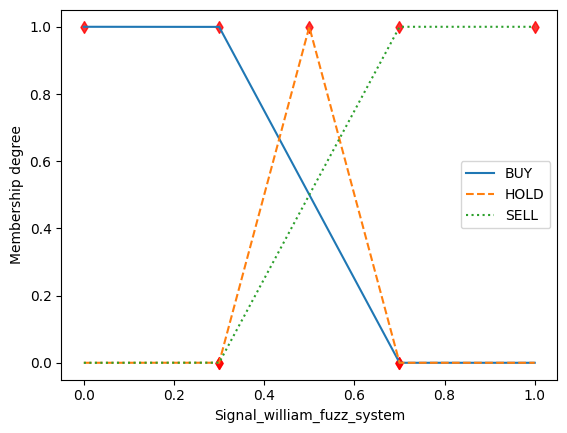

In [284]:
FS.plot_variable('Signal_william_fuzz_system')

In [285]:
at_eur_1h['Signal_william_fuzz_system'].value_counts()

Signal_william_fuzz_system
HOLD    441
SELL    307
BUY     268
Name: count, dtype: int64

# =======================

##

In [11]:
# Zbliżone do ostregoo RSI

FS = sf.FuzzySystem()

# linguistic variable for the input
S1 = sf.FuzzySet(points=[[0, 1.], [30, 1.], [31, 0.]], term="low")
S2 = sf.FuzzySet(points=[[31, 1.], [50, 1.], [69, 0.]], term="medium")
S3 = sf.FuzzySet(points=[[69, 0.], [70, 1.], [100, 1.]], term="high")
LV = sf.LinguisticVariable([S1, S2, S3], universe_of_discourse=[0, 100])
FS.add_linguistic_variable("RSI", LV)


# linguistic variable for the output
# 0-0.3 = SELL, 0.5-0.7 = HOLD, 0.7-1 = BUY
S1 = sf.FuzzySet(points=[[0, 1.], [0.3, 1.], [0.7, 0.]], term="BUY")
S2 = sf.FuzzySet(points=[[0.3, 0.], [0.5, 1.], [0.7, 0.]], term="HOLD")
S3 = sf.FuzzySet(points=[[0.5, 0.], [0.7, 1.], [1.0, 1.]], term="SELL")
LV = sf.LinguisticVariable([S1, S2, S3], universe_of_discourse=[0, 1])
FS.add_linguistic_variable("Signal_RSI_fuzz_system", LV)


R1 = "IF (RSI IS low) THEN (Signal_RSI_fuzz_system IS SELL)"
R2 = "IF (RSI IS medium) THEN (Signal_RSI_fuzz_system IS HOLD)"
R3 = "IF (RSI IS high) THEN (Signal_RSI_fuzz_system IS BUY)"
FS.add_rules([R1, R2, R3])

at_eur_1h['Signal_RSI_fuzz_system'] = 'HOLD' 

# generate signals
for i, value in enumerate(at_eur_1h['RSI']):
    FS.set_variable("RSI", value)
    decision = FS.Mamdani_inference()['Signal_RSI_fuzz_system']
    
    if decision <= 0.3:
        at_eur_1h.loc[at_eur_1h.index[i], 'Signal_RSI_fuzz_system'] = 'SELL'
    elif decision >= 0.7:
        at_eur_1h.loc[at_eur_1h.index[i], 'Signal_RSI_fuzz_system'] = 'BUY'



  ____  __  _  _  ____  ____  _  _  __   
 / ___)(  )( \/ )(  _ \(  __)/ )( \(  ) v2.11.1 
 \___ \ )( / \/ \ ) __/ ) _) ) \/ (/ (_/\ 
 (____/(__)\_)(_/(__)  (__)  \____/\____/

 Created by Marco S. Nobile (m.s.nobile@tue.nl)
 and Simone Spolaor (simone.spolaor@unimib.it)



In [12]:
at_eur_1h['Signal_RSI_fuzz_system'].value_counts()

Signal_RSI_fuzz_system
HOLD    4099
BUY      618
SELL     582
Name: count, dtype: int64

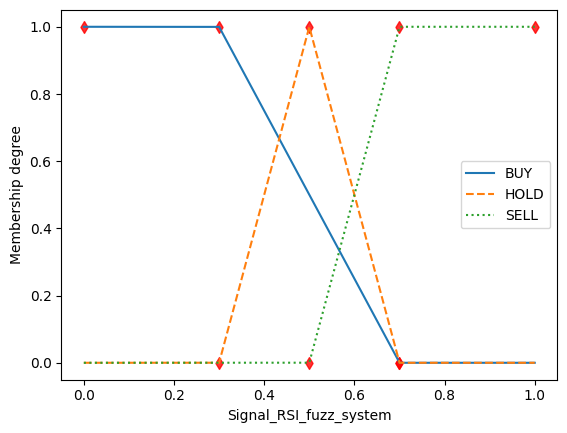

In [20]:
FS.plot_variable('Signal_RSI_fuzz_system')

dec_rsi
HOLD    4131
BUY      610
SELL     558
Name: count, dtype: int64